In [181]:
from ray.tune.analysis import Analysis
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
from copy import deepcopy
import json
from tqdm import tqdm
import pandas as pd
from helpers import *
from config import bursts_config_increase
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
# loading analysis
analysis = Analysis("/home/sergei/ray_results/adversarial_tune_bursts_exp_withnormal_pbt")

# loading summary dataframe
df = analysis.dataframe()

In [3]:
# loading one trial
r = df[df['config/_n_adversaries'] == 1].iloc[0]
rdf = get_df_from_logdir(r.logdir)

100%|██████████| 3090/3090 [00:13<00:00, 232.49it/s]


In [48]:
policies = set([x.split('/')[2] for x in rdf.columns if x.startswith('info/learner')])

In [81]:
fill_which_training(rdf)

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,policy_reward_min/player_1_from_scratch_001,policy_reward_min/player_2_pretrained,policy_reward_min/player_1_pretrained,policy_reward_max/player_1_from_scratch_001,policy_reward_max/player_2_pretrained,...,info/learner/player_2_pretrained/total_loss,info/learner/player_2_pretrained/entropy,info/learner/player_2_pretrained/vf_explained_var,info/learner/player_2_pretrained/kl,info/learner/player_2_pretrained/cur_kl_coeff,info/learner/player_2_pretrained/cur_lr,info/learner/player_2_pretrained/entropy_coeff,info/learner/player_2_pretrained/vf_loss,info/learner/player_2_pretrained/policy_loss,which_training
0,8.149737,-8.242243,3.324874,169.900369,271,-10.0,-18.242243,-10.0,10.0,18.149737,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,7.405834,-6.315979,2.983914,163.395760,283,-10.0,-16.315979,-10.0,10.0,17.405834,...,12.576793,2.704448,0.720895,0.039722,1.0,0.000755,0.009864,12.600284,-0.036537,2
2,9.068038,-5.127166,2.915734,163.262411,282,-10.0,-15.127166,-10.0,10.0,19.068038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,7.668674,-7.189343,3.264774,167.101449,276,-10.0,-17.189343,-10.0,10.0,17.668674,...,9.872883,2.758693,0.768425,0.043647,1.0,0.000755,0.009864,9.877162,-0.020715,2
4,7.971023,-4.551121,3.436162,168.178832,274,-10.0,-14.551121,-10.0,10.0,17.971023,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3085,8.028912,-8.830228,-0.925088,140.398176,329,-10.0,-18.830228,-10.0,10.0,18.028912,...,6.506535,59.921764,0.706705,0.005308,1.0,0.000755,0.009864,7.124081,-0.031799,2
3086,10.810504,-9.055211,-0.906292,140.471125,329,-10.0,-19.055211,-10.0,10.0,20.810504,...,5.057739,59.964046,0.724388,0.005685,1.0,0.000755,0.009864,5.658358,-0.014830,2
3087,10.628083,-6.901153,-1.260147,141.250765,327,-10.0,-16.901153,-10.0,10.0,20.628083,...,4.510837,59.998325,0.728225,0.005438,1.0,0.000755,0.009864,5.127837,-0.030626,2
3088,8.284838,-6.774395,-1.060863,140.169697,330,-10.0,-16.774395,-10.0,10.0,18.284838,...,3.904126,60.051075,0.737492,0.005506,1.0,0.000755,0.009864,4.503569,-0.012617,2


In [96]:
for k in rdf.columns:
    print(k)

episode_reward_max
episode_reward_min
episode_reward_mean
episode_len_mean
episodes_this_iter
policy_reward_min/player_1_from_scratch_001
policy_reward_min/player_2_pretrained
policy_reward_min/player_1_pretrained
policy_reward_max/player_1_from_scratch_001
policy_reward_max/player_2_pretrained
policy_reward_max/player_1_pretrained
policy_reward_mean/player_1_from_scratch_001
policy_reward_mean/player_2_pretrained
policy_reward_mean/player_1_pretrained
hist_stats/episode_reward
hist_stats/episode_lengths
hist_stats/policy_player_1_from_scratch_001_reward
hist_stats/policy_player_2_pretrained_reward
hist_stats/policy_player_1_pretrained_reward
sampler_perf/mean_env_wait_ms
sampler_perf/mean_processing_ms
sampler_perf/mean_inference_ms
num_healthy_workers
timesteps_total
timers/sample_time_ms
timers/sample_throughput
timers/learn_time_ms
timers/learn_throughput
timers/update_time_ms
info/learner/player_1_from_scratch_001/cur_kl_coeff
info/learner/player_1_from_scratch_001/cur_lr
info/lea

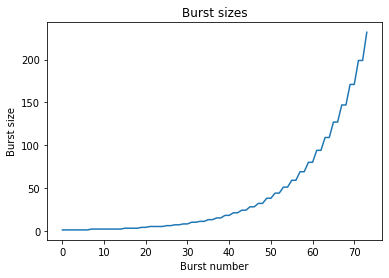

In [83]:
plt.title('Burst sizes')
plt.plot(burst_sizes(rdf['which_training']))
plt.xlabel('Burst number')
plt.ylabel('Burst size')
plt.show()

In [162]:
def iterate_bursts(rdf, target, min_size=5, state=None):
    """Iterate a function over all bursts."""
    seen_data = 0
    target_field = 'which_training'

    #with tqdm(total=len(rdf)) as pbar:
    while seen_data < len(rdf):
        accumulator = []
        for i in range(seen_data, len(rdf)):
            if (rdf.iloc[i][target_field] == rdf.iloc[seen_data][target_field]) or len(accumulator) < min_size:
                accumulator.append(rdf.iloc[i])
            else:
                break
        accumulator = pd.DataFrame(accumulator)
                
        state = target(rdf=rdf, trained_now=accumulator.iloc[0][target_field],
                       accumulator=accumulator, state=state)

        seen_data += len(accumulator)
            #pbar.update(len(accumulator))

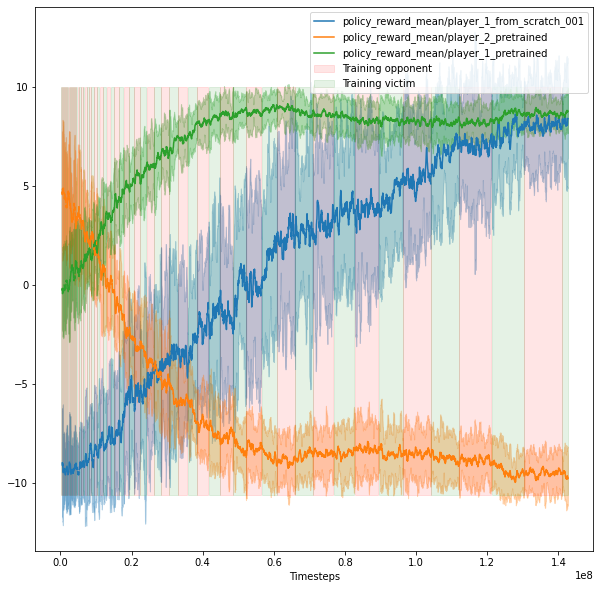

In [177]:
plt.figure(figsize=(10, 10))
plt.xlabel('Timesteps')

cols = [x for x in mcolors.TABLEAU_COLORS]  

c = cols[0]
fields = [x for x in rdf.columns if x.startswith('policy_reward_mean')]
colors = {f: cols[i] for i, f in enumerate(fields)}
rolling = 10

all_ys = {field: rdf[field] for field in fields}
all_ys_roll = {f: pd.Series(all_ys[f]).rolling(rolling) for f in fields}
all_ys_mean = {f: all_ys_roll[f].mean() for f in fields}
all_ys_std = {f: all_ys_roll[f].std() for f in fields}

min_metric = np.min([np.min(all_ys[f]) for f in fields])
max_metric = np.max([np.max(all_ys[f]) for f in fields])
            
def burst_line_plot(rdf, trained_now, accumulator, rolling=10, state=None):
    """Plot lines from accumulator."""
    
    xs = accumulator['timesteps_total']
    
    colors_bg = {1: "red", 2: "green"}
    labels_bg = {1: "Training opponent", 2: "Training victim"}

    
    for f in fields:
        ys = all_ys_mean[f][min(accumulator.index):max(accumulator.index) + 1]
        ys_std = all_ys_std[f][min(accumulator.index):max(accumulator.index) + 1]


        plt.plot(xs, ys, color=colors[f], alpha=1, label=f if 'legend_y' not in state else None)
        plt.fill_between(xs, ys - 3 * ys_std, ys + 3 * ys_std, color=colors[f], alpha=0.3)
    state['legend_y'] = True
    
    
    plt.fill_between(xs, min_metric, max_metric, alpha=0.1, color=colors_bg[trained_now],
                     label=labels_bg[trained_now] if trained_now not in state else None)
    state[trained_now] = True
    
    return state
    
iterate_bursts(rdf, burst_line_plot, state={})

plt.legend()
plt.show()

In [197]:
c = np.array(range(len(rdf))) * 1.0
plt.plot(rdf['policy_reward_mean/player_1_pretrained'], rdf['policy_reward_mean/player_1_from_scratch_001'], c=c)

ValueError: RGBA sequence should have length 3 or 4

<Figure size 432x288 with 1 Axes>

In [206]:
dfs = {}
for _, r in tqdm(df.iterrows()):
    rdf = get_df_from_logdir(r.logdir, do_tqdm=False)
    dfs[r.logdir] = rdf


0it [00:00, ?it/s]
1it [00:12, 12.66s/it]
2it [00:26, 13.08s/it]
3it [00:44, 14.47s/it]
4it [01:03, 15.73s/it]
5it [01:20, 16.36s/it]
6it [01:35, 15.76s/it]
7it [01:50, 15.54s/it]
8it [02:06, 15.67s/it]
9it [02:22, 15.69s/it]
10it [02:36, 15.34s/it]
11it [02:50, 15.01s/it]
12it [03:05, 14.99s/it]
13it [03:21, 15.23s/it]
14it [03:38, 15.83s/it]
15it [03:57, 16.64s/it]
16it [04:14, 15.91s/it]


In [204]:
plt.figure()
plt.scatter(df['config/_p_normal'], df['policy_reward_mean/player_2_pretrained_initial'])
plt.xlabel('p normal')
plt.ylabel('player 2 reward initial')
plt.show()

KeyError: 'policy_reward_mean/player_2_pretrained_initial'

<Figure size 432x288 with 0 Axes>

0     0.714912
1     0.399966
2     0.618873
3     0.775849
4     0.637218
5     0.542055
6     0.856538
7     0.180720
8     0.314444
9     0.259801
10    0.226707
11    0.132503
12    0.383572
13    0.264837
14    0.316713
15    0.189108
Name: config/_p_normal, dtype: float64

In [ ]:
burst size VS normal opponent performance / old opponent performance
noisy? pareto-optimal normal opponent VS adversarial opponent
does burst size matter at all?
linear regression initial reward of player 2 w.r.t. p_normal in PBT
plot value fcn loss wrt n adversaries/p normal
  also weird for bursts_exponent experiment
why is victim still losing even with having larger effective batch size
test if RLLIb is indeed doing what we expect with the batch size

what makes noise in player1 reward increase in
train_one_with_sacred_8__burst_exponent=1.5505,_n_adversaries=1,_p_normal=0.18072,entropy_coeff=0.0055567_2020-09-01_13-19-584ab6ver4
train_one_with_sacred_10__burst_exponent=1.1633,_n_adversaries=1,_p_normal=0.85654,entropy_coeff=0.0098638_2020-09-01_13-19-58b6ou0dsh

get rollouts and try fitting the value function with more neurons



In [ ]:
results should be similar to icml paper
  1 pretrained adversary + 1 normal opponent
  train the victim only, expect reasonable win rate for the victim

-- after sb working!

try sending data to stable baselines trainer +

policy loss for p2 is very noisy. improve pbt setup? read alphago paper
  vf loss goes up. why?
